# Transfer Learning
- VGG 모델을 이용해 전이학습 실시
- CIFAR10에 대해 진행

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

# Datasets

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_batch = 128
test_batch = 16
data_path = r'C:\Users\gjust\Documents\Github\data'

trainset = torchvision.datasets.CIFAR10(root=data_path, train = True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=data_path, train = False,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch,
                                          shuffle = True, num_workers = 1)
testloader = torch.utils.data.DataLoader(testset, batch_size = test_batch,
                                          shuffle = True, num_workers = 1)

Files already downloaded and verified
Files already downloaded and verified


# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


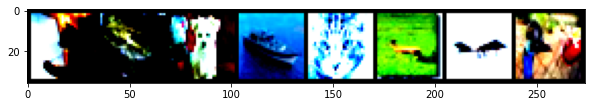

In [3]:
example = iter(trainloader).next()
ex_image, _ = example

ex_im = ex_image[:8]
ex_im = torchvision.utils.make_grid(ex_im)
ex_im = ex_im.permute(1,2,0)

plt.figure(figsize = (10,10))
plt.imshow(ex_im)

# GPU

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)   

cuda


# Finetuning

### Model

In [5]:
from torchvision import models

vgg = models.vgg16(pretrained=True)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
# 출력층 수정하기
vgg.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
vgg.to(device)

vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

### Hyper Parameters

In [7]:
EPOCH = 100
learning_rate = 0.001

optimizer = optim.SGD(vgg.classifier.parameters(), lr = learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

### Train

In [8]:
import time

vgg.train()
finetune_loss = []
for e in range(1, EPOCH+1):
    start_time = time.time()
    running_loss = 0
    for i, data in enumerate(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        
        now = time.time()
        print('\r EPOCH : [%d/%d], ITER : [%d/%d] LOSS : %.7f, Time : %d' 
              %(e, EPOCH, i+1, len(trainloader), running_loss, now - start_time), end = '')
        
    finetune_loss.append(running_loss.item())
    print('')

 EPOCH : [1/100], ITER : [391/391] LOSS : 498.1508789, Time : 28
 EPOCH : [2/100], ITER : [391/391] LOSS : 423.3513184, Time : 26
 EPOCH : [3/100], ITER : [391/391] LOSS : 398.5933838, Time : 26
 EPOCH : [4/100], ITER : [391/391] LOSS : 379.2492371, Time : 26
 EPOCH : [5/100], ITER : [391/391] LOSS : 367.5944519, Time : 26
 EPOCH : [6/100], ITER : [391/391] LOSS : 354.8654175, Time : 26
 EPOCH : [7/100], ITER : [391/391] LOSS : 345.7803955, Time : 26
 EPOCH : [8/100], ITER : [391/391] LOSS : 336.3439331, Time : 26
 EPOCH : [9/100], ITER : [391/391] LOSS : 327.1397095, Time : 26
 EPOCH : [10/100], ITER : [391/391] LOSS : 318.1529236, Time : 26
 EPOCH : [11/100], ITER : [391/391] LOSS : 310.7338562, Time : 26
 EPOCH : [12/100], ITER : [391/391] LOSS : 303.6820068, Time : 25
 EPOCH : [13/100], ITER : [391/391] LOSS : 296.1032715, Time : 25
 EPOCH : [14/100], ITER : [391/391] LOSS : 287.8992920, Time : 26
 EPOCH : [15/100], ITER : [391/391] LOSS : 280.3243103, Time : 26
 EPOCH : [16/100], 

### Test

In [9]:
vgg.eval()
correct = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        val_images, val_labels = data
        
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = vgg(val_images)
        pred = val_outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(val_labels.view_as(pred)).sum().item()
        
print('Accuracy of the network on 10000 test images : %.3f %%' %(100 * correct / len(testloader.dataset)))               

Accuracy of the network on 10000 test images : 70.670 %


# Transfer Learning

### model

In [10]:
from torchvision import models

vgg = models.vgg16(pretrained=True)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
# 출력층 수정하기
vgg.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
vgg.to(device)

vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [12]:
print('Name -------- Trainable')
print('*'*25)
for name, p in vgg.named_parameters():
    print(f'{name} ---------- {p.requires_grad}')

Name -------- Trainable
*************************
features.0.weight ---------- True
features.0.bias ---------- True
features.2.weight ---------- True
features.2.bias ---------- True
features.5.weight ---------- True
features.5.bias ---------- True
features.7.weight ---------- True
features.7.bias ---------- True
features.10.weight ---------- True
features.10.bias ---------- True
features.12.weight ---------- True
features.12.bias ---------- True
features.14.weight ---------- True
features.14.bias ---------- True
features.17.weight ---------- True
features.17.bias ---------- True
features.19.weight ---------- True
features.19.bias ---------- True
features.21.weight ---------- True
features.21.bias ---------- True
features.24.weight ---------- True
features.24.bias ---------- True
features.26.weight ---------- True
features.26.bias ---------- True
features.28.weight ---------- True
features.28.bias ---------- True
classifier.0.weight ---------- True
classifier.0.bias ---------- True
clas

In [13]:
# 모델 고정하기(학습x)
for p in vgg.features.parameters():
    p.requires_grad = False

In [14]:
print('Name -------- Trainable')
print('*'*25)
for name, p in vgg.named_parameters():
    print(f'{name} ---------- {p.requires_grad}')

Name -------- Trainable
*************************
features.0.weight ---------- False
features.0.bias ---------- False
features.2.weight ---------- False
features.2.bias ---------- False
features.5.weight ---------- False
features.5.bias ---------- False
features.7.weight ---------- False
features.7.bias ---------- False
features.10.weight ---------- False
features.10.bias ---------- False
features.12.weight ---------- False
features.12.bias ---------- False
features.14.weight ---------- False
features.14.bias ---------- False
features.17.weight ---------- False
features.17.bias ---------- False
features.19.weight ---------- False
features.19.bias ---------- False
features.21.weight ---------- False
features.21.bias ---------- False
features.24.weight ---------- False
features.24.bias ---------- False
features.26.weight ---------- False
features.26.bias ---------- False
features.28.weight ---------- False
features.28.bias ---------- False
classifier.0.weight ---------- True
classifier.0

### Hyper Parameters

In [15]:
EPOCH = 100
learning_rate = 0.001

optimizer = optim.SGD(vgg.classifier.parameters(), lr = learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

In [16]:
import time

vgg.train()
transfer_loss = []
for e in range(1, EPOCH+1):
    start_time = time.time()
    running_loss = 0
    for i, data in enumerate(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        
        now = time.time()
        print('\r EPOCH : [%d/%d], ITER : [%d/%d] LOSS : %.7f, Time : %d' 
              %(e, EPOCH, i+1, len(trainloader), running_loss, now - start_time), end = '')
        
    transfer_loss.append(running_loss.item())
    print('')

 EPOCH : [1/100], ITER : [391/391] LOSS : 496.6756287, Time : 16
 EPOCH : [2/100], ITER : [391/391] LOSS : 424.2672729, Time : 16
 EPOCH : [3/100], ITER : [391/391] LOSS : 397.3881836, Time : 16
 EPOCH : [4/100], ITER : [391/391] LOSS : 379.4682312, Time : 16
 EPOCH : [5/100], ITER : [391/391] LOSS : 366.5937500, Time : 16
 EPOCH : [6/100], ITER : [391/391] LOSS : 355.9624634, Time : 16
 EPOCH : [7/100], ITER : [391/391] LOSS : 344.3586426, Time : 16
 EPOCH : [8/100], ITER : [391/391] LOSS : 335.5644836, Time : 16
 EPOCH : [9/100], ITER : [391/391] LOSS : 326.6748352, Time : 16
 EPOCH : [10/100], ITER : [391/391] LOSS : 319.0537720, Time : 16
 EPOCH : [11/100], ITER : [391/391] LOSS : 311.1722717, Time : 16
 EPOCH : [12/100], ITER : [391/391] LOSS : 303.9424133, Time : 16
 EPOCH : [13/100], ITER : [391/391] LOSS : 296.4164734, Time : 16
 EPOCH : [14/100], ITER : [391/391] LOSS : 288.7652893, Time : 16
 EPOCH : [15/100], ITER : [391/391] LOSS : 281.9829712, Time : 16
 EPOCH : [16/100], 

In [17]:
vgg.eval()
correct = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        val_images, val_labels = data
        
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = vgg(val_images)
        pred = val_outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(val_labels.view_as(pred)).sum().item()
        
print('Accuracy of the network on 10000 test images : %.3f %%' %(100 * correct / len(testloader.dataset)))               

Accuracy of the network on 10000 test images : 70.350 %


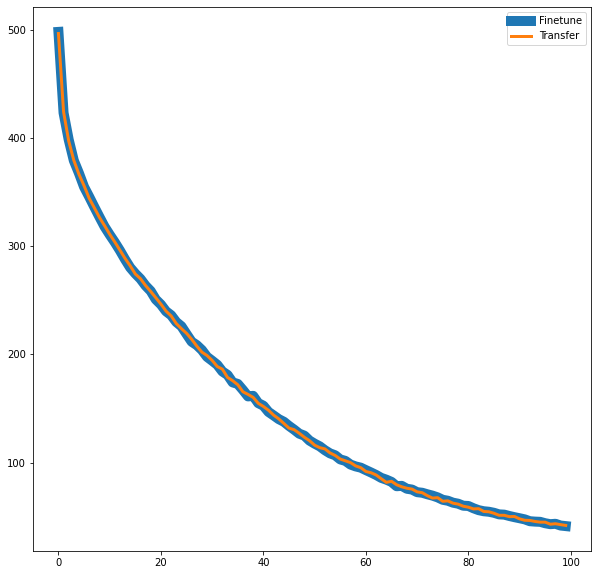

In [40]:
plt.figure(figsize=(10,10))

plt.plot(fine, linewidth=10)
plt.plot(trans, linewidth=3)
plt.legend(['Finetune', 'Transfer'])